# Finding the optimal location for a supermarket in Hyderabad

 ## Introduction


Opening a physical store is not without risks. One the most obvious risks to evaluate before opening a new store is receiving enough customers to make the business profitable. Therefore it is essential to pick the right location to make sure it is convenient for the customers and there is enough demand for a new store in the area.

## Business problem 

In this project, we tackle the problem of supermarket chain trying to decide in which area of hyderabad they should open their new store in order to maximise the revenue. It is important to note that the city of Hyderbad consists of 243 neighbourhoods with great differences between them.

The goal is to identify the optimal neighbourhood for opening a store taking different factors into consideration such as the types of neighbourhood (a residential area would be ideal), the amount of people living in those areas (the higher the population the higher the food demand)

Using data science, geospatial analysis and machine learning techniques, this project aims to provide a solution for this problem and recommending the best neighbourhood for opening the low-cost supermarket.

In [ ]:
!pip install geocoder
!pip install geopy
!pip install bs4
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 7.2 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/


### Libraries import

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
import geocoder 
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt


### Scrapping Wikipedia

## URL for Wikipedia article

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Hyderabad'
soup = BeautifulSoup(requests.get(url).content, 'html.parser')
hyd_neighbourhoods = []

for tag in soup.select('p:contains("Hyderabad Central is also called as New City, Because it was developed after Old City.") ~ ul > li '):
    if tag.name == 'li':
        hyd_neighbourhoods.append(tag.find(text=True).replace('\n', '').rstrip().lstrip().upper())
        
df_hyd = pd.DataFrame(hyd_neighbourhoods, columns=['Neighbourhood'])
print(f'Shape: {df_hyd.shape}')
df_hyd
            

   

Shape: (244, 1)


,Neighbourhood
0,AMEERPET
1,BEGUMPET
2,SR NAGAR
3,PRAKASH NAGAR
4,PUNJAGUTTA
...,...
239,NARSINGI
240,PUPPALGUDA
241,SHAMSHABAD
242,RAJIV GANDHI INTERNATIONAL AIRPORT


### Getting geographical coordinates for the neighbourhoods

In [4]:
def get_coordinates(row):
    # initialize variable to None
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{row["Neighbourhood"]}, Hyderabad')
      lat_lng_coords = g.latlng
    
    # return pair lat,long
    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])
    
# Fill coordinates for each row
df_hyd[['Latitude','Longitude']] = df_hyd.apply(get_coordinates, axis=1)
df_hyd.head()

,Neighbourhood,Latitude,Longitude
0,AMEERPET,17.43535,78.44861
1,BEGUMPET,17.44729,78.45396
2,SR NAGAR,17.49808,78.46963
3,PRAKASH NAGAR,17.36069,78.41634
4,PUNJAGUTTA,17.42616,78.45210


In [5]:
address = 'Hyderabad'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad are 17.360589, 78.4740613.


In [6]:
map_hyderabad = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, label in zip(df_hyd['Latitude'], df_hyd['Longitude'], df_hyd['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyderabad)  
    
map_hyderabad

In [7]:
CLIENT_ID = 'G330HVUPVVYEBBFUKNOU2GWNQCUU3XF1B4PZLGNMQR5TKJBS' # your Foursquare ID
CLIENT_SECRET = 'S0K4P41WPS51YGTGCXRTLMMGXIV4A2PIGLLBBULAA0XSKKUX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G330HVUPVVYEBBFUKNOU2GWNQCUU3XF1B4PZLGNMQR5TKJBS
CLIENT_SECRET:S0K4P41WPS51YGTGCXRTLMMGXIV4A2PIGLLBBULAA0XSKKUX


### Requesting Foursquare API for geospatial data

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


,name,categories,lat,lng
0,Chowmahala Palace,History Museum,17.359300,78.471617
1,Charminar,Monument / Landmark,17.361555,78.474677
2,Govind Ki Idly,South Indian Restaurant,17.364132,78.473771
3,Nimrah Hotel,Café,17.361136,78.474373
4,Pista house,Indian Restaurant,17.356609,78.473637
5,Cafe coffee day,Coffee Shop,17.361987,78.474908
6,Choodi bazar,Clothing Store,17.361951,78.474642
7,Matwale Doodh Ghar,Dessert Shop,17.356657,78.473682


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Search for venues within 1Km of radius from the neighbourhood centre point
radius = 1000

# Call the above function
hyd_venues = getNearbyVenues(names=df_hyd['Neighbourhood'],
                                   latitudes=df_hyd['Latitude'],
                                   longitudes=df_hyd['Longitude'],
                                   radius=radius)

print(hyd_venues.shape)
hyd_venues.head()  

(22136, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AMEERPET,17.43535,78.44861,Ameerpet Gurudwara,17.435822,78.448137,Sikh Temple
1,AMEERPET,17.43535,78.44861,Delhi Mithaiwala,17.434558,78.447860,Candy Store
2,AMEERPET,17.43535,78.44861,Riche Rich Bakery,17.434628,78.449000,Bakery
3,AMEERPET,17.43535,78.44861,Ratnadeep Super Market Ameerpet,17.435067,78.449919,Department Store
4,AMEERPET,17.43535,78.44861,Aditya Park,17.434419,78.448126,Hotel Pool


In [12]:
hyd_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
A. S. RAO NAGAR,82,82,82,82,82,82
A.C. GUARDS,85,85,85,85,85,85
ABIDS,89,89,89,89,89,89
ADIKMET,92,92,92,92,92,92
AFZAL GUNJ,86,86,86,86,86,86
...,...,...,...,...,...,...
VINAYAK NAGAR,98,98,98,98,98,98
WARSIGUDA,93,93,93,93,93,93
YAKUTPURA,92,92,92,92,92,92


### Analysing each neighbourhood

In [13]:
# one hot encoding
hyd_onehot = pd.get_dummies(hyd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
hyd_onehot['Neighbourhood'] = hyd_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [hyd_onehot.columns[-1]] + list(hyd_onehot.columns[:-1])
hyd_onehot = hyd_onehot[fixed_columns]

# group rows by neighbourhood and find frequency of each category
hyd_grouped = hyd_onehot.groupby('Neighbourhood').mean().reset_index()
print(f'Size: {hyd_grouped.shape}')
hyd_grouped.head()

Size: (243, 494)


,Neighbourhood,ATM,Accessories Store,Acupuncturist,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,...,Wedding Hall,Well,Whisky Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,A. S. RAO NAGAR,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,A.C. GUARDS,0.0,0.0,0.0,0.0,0.0,0.011765,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023529,0.0,0.0,0.0
2,ABIDS,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067416,0.0,0.0,0.0
3,ADIKMET,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,AFZAL GUNJ,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Neighbourhood segmentation 

#### Converting into a Dataframe

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [15]:
hyd_grouped.shape[0]

243

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = hyd_grouped['Neighbourhood']

for ind in np.arange(hyd_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyd_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. S. RAO NAGAR,Residential Building (Apartment / Condo),Bank,Office,Gym,Clothing Store,Salon / Barbershop,Bakery,Café,Pizza Place,Building
1,A.C. GUARDS,Residential Building (Apartment / Condo),Hospital,Government Building,Salon / Barbershop,Miscellaneous Shop,Student Center,Bank,Indian Restaurant,Café,Non-Profit
2,ABIDS,Shoe Store,Women's Store,Boutique,Bank,Men's Store,Hotel,Indian Restaurant,Miscellaneous Shop,Bridal Shop,Tailor Shop
3,ADIKMET,Café,Bank,Bakery,Ice Cream Shop,Residential Building (Apartment / Condo),Coffee Shop,Office,Snack Place,Pizza Place,Building
4,AFZAL GUNJ,Bank,Bakery,Office,Building,Indian Restaurant,Bookstore,Automotive Shop,History Museum,Snack Place,Residential Building (Apartment / Condo)


### Finding optimum number of clusters by the elbow method

1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

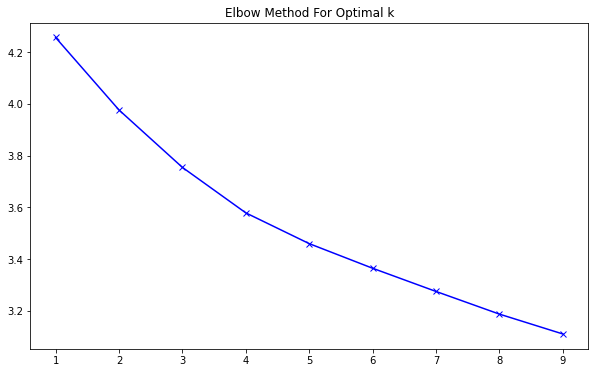

In [17]:
hyd_grouped_clustering = hyd_grouped.drop('Neighbourhood', 1)
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(hyd_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')


### Clustering neighbourhoods

Run k-means to cluster the neighbourhoods into 5 clusters.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

for ind in np.arange(hyd_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyd_grouped.iloc[ind, :], num_top_venues)


In [19]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(hyd_grouped_clustering)

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hyd_merged = df_hyd

# merge madrid_grouped with df_madrid to add latitude/longitude for each neighbourhood
hyd_merged = hyd_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

hyd_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AMEERPET,17.43535,78.44861,3,Electronics Store,Bakery,Building,Women's Store,Residential Building (Apartment / Condo),Clothing Store,Miscellaneous Shop,Indian Restaurant,Department Store,Temple
1,BEGUMPET,17.44729,78.45396,4,Residential Building (Apartment / Condo),Office,Indian Restaurant,Temple,Café,Coworking Space,Building,Restaurant,Dentist's Office,Housing Development
2,SR NAGAR,17.49808,78.46963,1,Bank,Optical Shop,Housing Development,Bakery,Salon / Barbershop,Automotive Shop,Hospital,Motorcycle Shop,Breakfast Spot,Clothing Store
3,PRAKASH NAGAR,17.36069,78.41634,4,Residential Building (Apartment / Condo),Bank,Fast Food Restaurant,Restaurant,Electronics Store,Bakery,General College & University,Market,Grocery Store,Indian Restaurant
4,PUNJAGUTTA,17.42616,78.45210,3,Indian Restaurant,Multiplex,Fast Food Restaurant,Jewelry Store,Kids Store,Electronics Store,Bank,Miscellaneous Shop,Professional & Other Places,Bike Shop


### Visualzing the clusters 

In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyd_merged['Latitude'], hyd_merged['Longitude'], hyd_merged['Neighbourhood'], hyd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [21]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 0, hyd_merged.columns[[0] + list(range(4, hyd_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,SANATHNAGAR,Automotive Shop,Residential Building (Apartment / Condo),Office,Factory,High School,Hospital,Building,Bank,Train Station,Café
138,MOOSAPET,Automotive Shop,Office,Factory,Bank,Government Building,Building,Movie Theater,Indie Movie Theater,Indian Restaurant,Event Space
139,MALLAMPET,Housing Development,Residential Building (Apartment / Condo),Factory,College Academic Building,Office,College Classroom,Bank,Indian Restaurant,Gym,College Cafeteria
140,PATANCHERU,Bank,Factory,Indian Restaurant,Gas Station,Diner,Snack Place,College Engineering Building,General Entertainment,Post Office,Government Building
142,RC PURAM,Factory,Residential Building (Apartment / Condo),Hospital,Indian Restaurant,Assisted Living,Church,Clothing Store,Indie Movie Theater,College Academic Building,Student Center
143,AMEENPUR,Residential Building (Apartment / Condo),Factory,Bank,Bar,Indian Restaurant,Office,Building,Pool,Department Store,Bus Line
144,BEERAMGUDA,Bank,Indian Restaurant,Residential Building (Apartment / Condo),Automotive Shop,Movie Theater,Factory,Gas Station,Snack Place,Government Building,Hotel
145,KISTAREDDYPET,Factory,Bank,Residential Building (Apartment / Condo),Indian Restaurant,Snack Place,Gas Station,Café,Restaurant,General Entertainment,Hotel
146,IDA BOLLARAM,Factory,Residential Building (Apartment / Condo),Housing Development,Office,Bank,Hospital,Bar,College Classroom,Student Center,Building
149,FATEH NAGAR,Office,Automotive Shop,Building,Factory,Indian Restaurant,Bank,Residential Building (Apartment / Condo),Train Station,Café,Bridge


### Cluster 2

In [22]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 1, hyd_merged.columns[[0] + list(range(4, hyd_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,SR NAGAR,Bank,Optical Shop,Housing Development,Bakery,Salon / Barbershop,Automotive Shop,Hospital,Motorcycle Shop,Breakfast Spot,Clothing Store
22,ASHOK NAGAR,Bank,Automotive Shop,Indian Restaurant,Snack Place,Bakery,Ice Cream Shop,Department Store,Movie Theater,Residential Building (Apartment / Condo),Temple
29,SHANKER MUTT,Bank,Residential Building (Apartment / Condo),Hospital,Snack Place,Bakery,Indian Restaurant,College Academic Building,Building,Student Center,Gas Station
36,BARKATPURA,Hospital,Bank,Salon / Barbershop,Gym,Coffee Shop,Movie Theater,Residential Building (Apartment / Condo),Dessert Shop,Bike Shop,Cosmetics Shop
38,JAMIA OSMANIA,Café,Bank,Chinese Restaurant,University,Snack Place,College Academic Building,College Administrative Building,Food Truck,Residential Building (Apartment / Condo),General College & University
39,KACHIGUDA,Bank,Snack Place,Coffee Shop,Non-Profit,Hotel,Building,Hospital,Multiplex,Temple,Movie Theater
44,KOTI,Bank,Electronics Store,Miscellaneous Shop,Clothing Store,Women's Store,Optical Shop,Hospital,Bookstore,Hotel,Music Store
51,MADANNAPET,Bank,Bakery,Department Store,Temple,Mosque,Doctor's Office,Pharmacy,Breakfast Spot,Café,Vegetarian / Vegan Restaurant
56,PAN BAZAR,Hardware Store,Electronics Store,Bank,Indian Restaurant,Jewelry Store,Office,Temple,Mobile Phone Shop,Motel,Hotel
66,BOWENPALLY,Bank,Indian Restaurant,Gas Station,Bakery,Fast Food Restaurant,Chinese Restaurant,Salon / Barbershop,Snack Place,Dessert Shop,Housing Development


### Cluster 3

In [23]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 2, hyd_merged.columns[[0] + list(range(4, hyd_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,SOMAJIGUDA,Office,Bank,Building,Café,Indian Restaurant,Restaurant,Pizza Place,Residential Building (Apartment / Condo),College Academic Building,Burger Joint
13,RAJ BHAVAN ROAD,Office,Indian Restaurant,Bike Shop,Building,Hospital,Clothing Store,Residential Building (Apartment / Condo),Electronics Store,Furniture / Home Store,Breakfast Spot
15,SAIFABAD,Office,Government Building,Indian Restaurant,Hospital,Building,Bank,Embassy / Consulate,Capitol Building,Planetarium,College Academic Building
52,MINISTER ROAD,Office,Men's Store,Bank,Hotel,Hardware Store,Electronics Store,Furniture / Home Store,Mobile Phone Shop,Motel,Building
59,RANI GUNJ,Hardware Store,Office,Electronics Store,Hotel,Café,Building,Furniture / Home Store,Bank,Temple,Fast Food Restaurant
61,SINDHI COLONY,Office,Bakery,Pizza Place,Ice Cream Shop,Café,Coffee Shop,Automotive Shop,Bank,Shoe Store,Tech Startup
113,HITEC CITY,Office,Conference Room,Cafeteria,Café,Indian Restaurant,Business Center,Coffee Shop,Deli / Bodega,Hotel,Coworking Space
114,MADHAPUR,Miscellaneous Shop,Clothing Store,Office,Residential Building (Apartment / Condo),Café,Indian Restaurant,Fast Food Restaurant,Automotive Shop,Gym,Bakery
116,JUBILEE HILLS,Office,Furniture / Home Store,Pizza Place,Brewery,Restaurant,Clothing Store,Residential Building (Apartment / Condo),Lake,Food Court,Housing Development
117,BANJARA HILLS,Office,Furniture / Home Store,Indian Restaurant,Boutique,Bank,Café,Tech Startup,Restaurant,Hookah Bar,Ice Cream Shop


### Cluster 4

In [24]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 3, hyd_merged.columns[[0] + list(range(4, hyd_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AMEERPET,Electronics Store,Bakery,Building,Women's Store,Residential Building (Apartment / Condo),Clothing Store,Miscellaneous Shop,Indian Restaurant,Department Store,Temple
4,PUNJAGUTTA,Indian Restaurant,Multiplex,Fast Food Restaurant,Jewelry Store,Kids Store,Electronics Store,Bank,Miscellaneous Shop,Professional & Other Places,Bike Shop
11,KHAIRTABAD,Indian Restaurant,Building,Hospital,Paper / Office Supplies Store,Government Building,Bakery,Mosque,Office,College Classroom,Hotel
17,MASAB TANK,Indian Restaurant,Residential Building (Apartment / Condo),Government Building,Convenience Store,Salon / Barbershop,College Academic Building,Restaurant,Bank,Bakery,Bookstore
20,CHIKKADPALLY,Indian Restaurant,Building,Bank,Snack Place,College Academic Building,Doctor's Office,Non-Profit,Diner,Pizza Place,Auto Dealership
...,...,...,...,...,...,...,...,...,...,...,...
222,SANTOSHNAGAR,Clothing Store,Indian Restaurant,Residential Building (Apartment / Condo),Office,Hospital,Student Center,Bank,Café,Coworking Space,College Engineering Building
225,MEHDIPATNAM,Fast Food Restaurant,Hospital,Salon / Barbershop,Indian Restaurant,Department Store,Office,Bookstore,Bank,Pharmacy,Café
226,TOLI CHOWKI,Indian Restaurant,Salon / Barbershop,Pizza Place,Café,Residential Building (Apartment / Condo),Mosque,Bridal Shop,Ice Cream Shop,Men's Store,Clothing Store
232,PADMANABHA NAGAR COLONY,Indian Restaurant,Residential Building (Apartment / Condo),Event Space,Gas Station,Hospital,Bank,Mosque,Bus Line,Auto Workshop,Medical Center


### Cluster 5

In [25]:
hyd_merged.loc[hyd_merged['Cluster Labels'] == 4, hyd_merged.columns[[0] + list(range(4, hyd_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,BEGUMPET,Residential Building (Apartment / Condo),Office,Indian Restaurant,Temple,Café,Coworking Space,Building,Restaurant,Dentist's Office,Housing Development
3,PRAKASH NAGAR,Residential Building (Apartment / Condo),Bank,Fast Food Restaurant,Restaurant,Electronics Store,Bakery,General College & University,Market,Grocery Store,Indian Restaurant
5,BALKAMPET,Residential Building (Apartment / Condo),Indian Restaurant,Temple,Office,Café,Bank,Hospital,Automotive Shop,Coworking Space,Bakery
7,BHARAT NAGAR,Residential Building (Apartment / Condo),Bank,Indian Restaurant,Housing Development,Temple,Bus Station,Military Base,Mobile Phone Shop,Golf Course,Bar
8,ERRAGADDA,Bank,Residential Building (Apartment / Condo),Doctor's Office,Office,Bakery,Automotive Shop,Bus Station,Breakfast Spot,Bar,Housing Development
...,...,...,...,...,...,...,...,...,...,...,...
229,LANGAR HOUZ,Residential Building (Apartment / Condo),Bank,Bakery,Temple,Grocery Store,Café,Salon / Barbershop,Electronics Store,Pizza Place,Gym
237,GANDIPET,Residential Building (Apartment / Condo),College Engineering Building,Lake,Food Truck,Farm,Event Space,Student Center,College Lab,College Administrative Building,Bakery
238,KISMATPUR,Residential Building (Apartment / Condo),Indian Restaurant,Bank,Mosque,Housing Development,Lake,Restaurant,Department Store,Farm,Event Space
239,NARSINGI,Residential Building (Apartment / Condo),Housing Development,Breakfast Spot,Bank,High School,Event Space,Snack Place,School,Bakery,Salon / Barbershop



### Selecting a cluster

By exploring the most frequent venues of each of the five clusters we can describe the clusters as follows:

| Cluster       | Type of area | Common venues|
|   ---         | ---          | ---          |
|      0        | Recreation   | Restaurents  |
|      1        |  Industrial  |   Factory    |
|      2        |  Education   | Colleges     |
|      3        |  Resedential | Houses       |
|      4        |   Business   | Offices      |



Therefore we will analyse the cluster 3 in detail since this is the one that refers to residential areas. This cluster contains 56 neighbourhoods

In [26]:
residential_cluster_id = 3
df_hyd_residential = df_hyd[df_hyd['Neighbourhood'].isin(hyd_merged.loc[hyd_merged['Cluster Labels'] == residential_cluster_id, 'Neighbourhood'])]

### Census data

In [27]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_47066bf6f8e54f7799bedeb0f3907d81 = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_47066bf6f8e54f7799bedeb0f3907d81 = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_47066bf6f8e54f7799bedeb0f3907d81 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ahtT-nF5jC1Gw6B88aJ83kmHtHL2NWEFCcbJTEUC9g9J',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_47066bf6f8e54f7799bedeb0f3907d81)

body = client_47066bf6f8e54f7799bedeb0f3907d81.get_object(Bucket='dataanalytics-donotdelete-pr-gsvqkwpmahboac',Key='Book 1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_hyd_popu_cluster = pd.read_csv(body)
df_hyd_popu_cluster.head()


,Neighbourhood,Population
0,BEGUMPET,92340
1,PRAKASH NAGAR,99543
2,BALKAMPET,21125
3,BHARATH NAGAR,52909
4,ERRAGADDA,47471


In [28]:
df_pop_sorted=df_hyd_popu_cluster[:55].sort_values(by=['Population'], ascending=False)


In [29]:
df_hyd_popu=df_pop_sorted[:10]

In [30]:
def get_coordinates(row):
    # initialize variable to None
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{row["Neighbourhood"]}, Hyderabad')
      lat_lng_coords = g.latlng
    
    # return pair lat,long
    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])
    
# Fill coordinates for each row
df_hyd_popu[['Latitude','Longitude']] = df_hyd_popu.apply(get_coordinates, axis=1)
df_hyd_popu

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Neighbourhood,Population,Latitude,Longitude
11,AMBERPET,181589,17.38582,78.51836
27,SHAIKPET HYDERABAD,123675,17.40373,78.39310
47,SAROORNAGAR,122440,17.35442,78.53921
1,PRAKASH NAGAR,99543,17.36069,78.41634
0,BEGUMPET,92340,17.44729,78.45396
32,NIZAMPET,84398,17.51831,78.38189
10,VIDYANAGAR,81023,17.40458,78.51031
9,BAGH LINGAMPALLY,79623,17.39931,78.49964
29,HAFEEZPET,79148,17.48990,78.35220
44,A. S. RAO NAGAR,78194,17.41120,78.50824


In [31]:
map_hyderabad = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, label in zip(df_hyd_popu['Latitude'], df_hyd_popu['Longitude'], df_hyd_popu['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyderabad)  
    
map_hyderabad

 ### Results and discussion
The following table represents the residential top 10 neighborhoods in cluster 3 considering the population. 

Above we can clearly see that Amberpet neighborhood having the highest population around 181k and we also know that the cluster 3 is the residential area so it is profitable to open a new store in the above areas.




### Conclusion

The neighborhoods of Hyderabad were analyzed with the purpose of finding the ideal location for a supermarket. We applied machine learning techniques such as k-means clustering to find different clusters so that we could focus in only one type of neighborhood (residential). Further data such as population and market venues have been used to reduce the number of potential areas.

This project could be improved by only taking certain venue categories into consideration when performing the clustering segmentation. We could for example identify the key types of venue that define a residential area such as schools, pharmacies, small markets and corner shops, and the types of venue that discard a residential area such as night clubs, theatres and so on. Another improvement could be achieved by only handling certain groups of ages and social classes that would normally shop in a supermarket.

Although this project focuses particularly in a  supermarket, it could easily be amended for any type of business and city, as long as the corresponding data are available to be included in the  analysis.

